# Plots and maps
In this notebook we show how to create plots from the data and the 2D fields.

There are different Julia packages allowing users to display their data.
- [`PyPlot`](https://github.com/JuliaPy/PyPlot.jl) is a Julia interface to the [`Matplotlib`](https://matplotlib.org/) (Python) plotting library, which uses the `PyCall` package to call the Python code.
- [`Makie`](https://docs.makie.org), a data visualization ecosystem written in Julia.

🗺️ For the creation of maps:
- `PyPlot` can work with modules such as [`cartopy`](https://scitools.org.uk/cartopy/docs/latest/) or [`Basemap`](https://matplotlib.org/basemap/stable/).
- `Makie` can be used in combination with [`GeoMakie`](https://geo.makie.or), which allows one to manage different coordinate reference systems (CRS).

<div class="alert alert-block alert-warning"> 
  ⚠️ The use of `PyPlot` (+ `cartopy` or `Basemap`) can lead to installation errors which are not always easy to solve. This is why we will focus more on the creation of figures with Makie.
</div>

## Packages

In [1]:
using Makie
using CairoMakie
using GeoMakie
using DIVAnd
using ColorSchemes
include("../config.jl")

"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

## Bathymetry and mask
### Download and load file

In [2]:
download_check(gebco08file, gebco08fileURL);
bx, by, b = extract_bath(gebco08file,true,9.:15.,54.:60.);
lonmask, latmask, mask = load_mask(gebco08file,true,9.:0.1:15.,54.:0.1:60., [0.])

[ Info: File already downloaded


(9.0:0.1:15.0, 54.0:0.1:60.0, Bool[1 1 … 0 0; 0 0 … 0 0; … ; 0 1 … 0 0; 0 0 … 0 0;;;])

### Plots
Here we will show the results obtained with `Makie` and with `GeoMakie` to show the difference.     
Then the plots will be only produced with `GeoMakie`
#### With Makie
We represent the bathymetry and specify
- the colormap (`Reverse(ColorSchemes.delta)`)
- the limits (`colorrange=[-500, 500]`).      

In addition, the contour corresponding to the surface (`levels=[0.]`) is added to show the coastline.     

A list of available colormaps can be found at https://docs.makie.org/dev/explanations/colors.

In [3]:
topocmap = Reverse(ColorSchemes.delta);

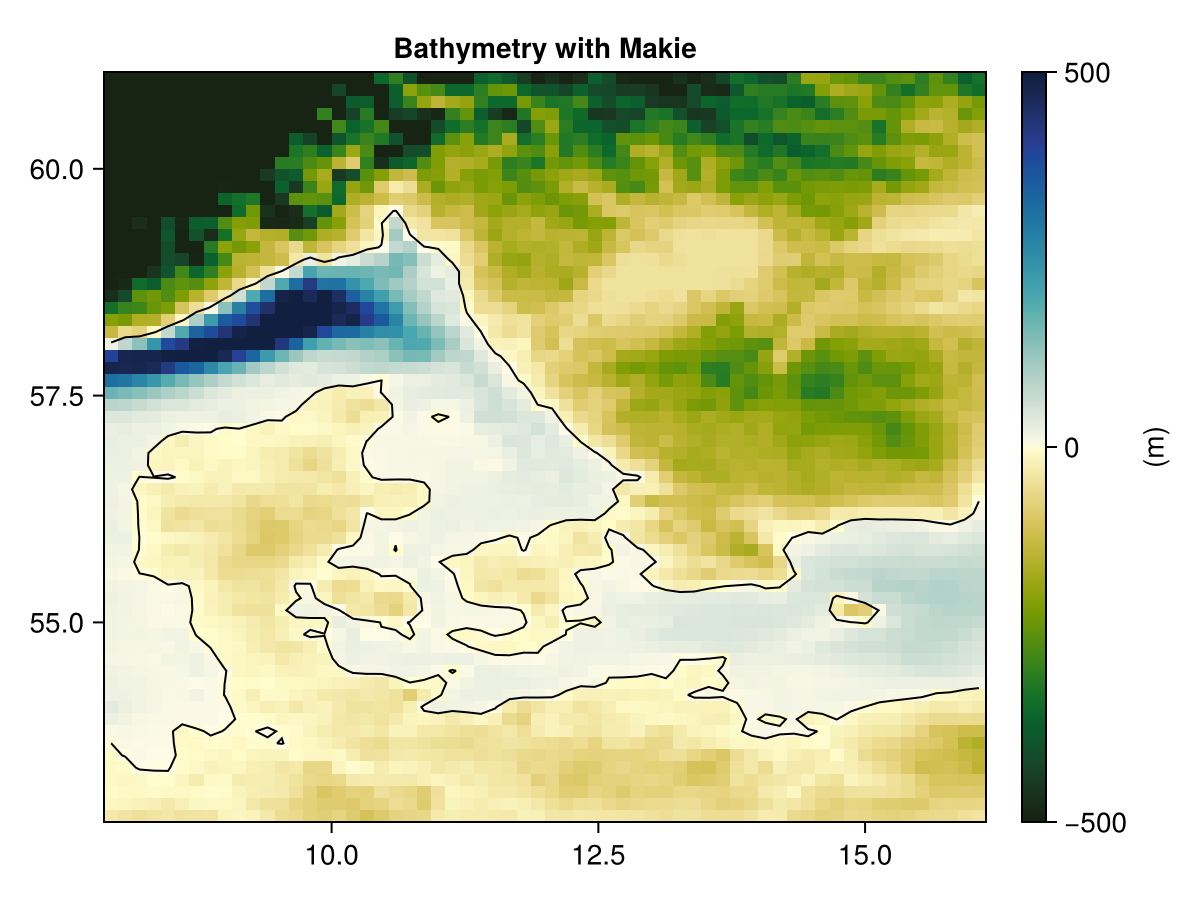

In [4]:
f = Figure()
ax = Axis(f[1,1], title="Bathymetry with Makie")
hm = heatmap!(ax, bx, by, b, colormap=topocmap, colorrange=[-500, 500])
contour!(ax, bx, by, b, levels=[0.], color=:black)
Colorbar(f[1,2], hm, label = "(m)")
f

#### With GeoMakie
The main difference with the previous plot is that we use a `GeoAxis` (instead of an `Axis`),      
for which we can define the coordinate reference system with the argument `dest = "+proj=merc"`.     
The available projections are those listed at https://proj.org/en/stable/operations/projections/index.html.      
The coastline can be added with `lines!(ax, GeoMakie.coastlines())`.

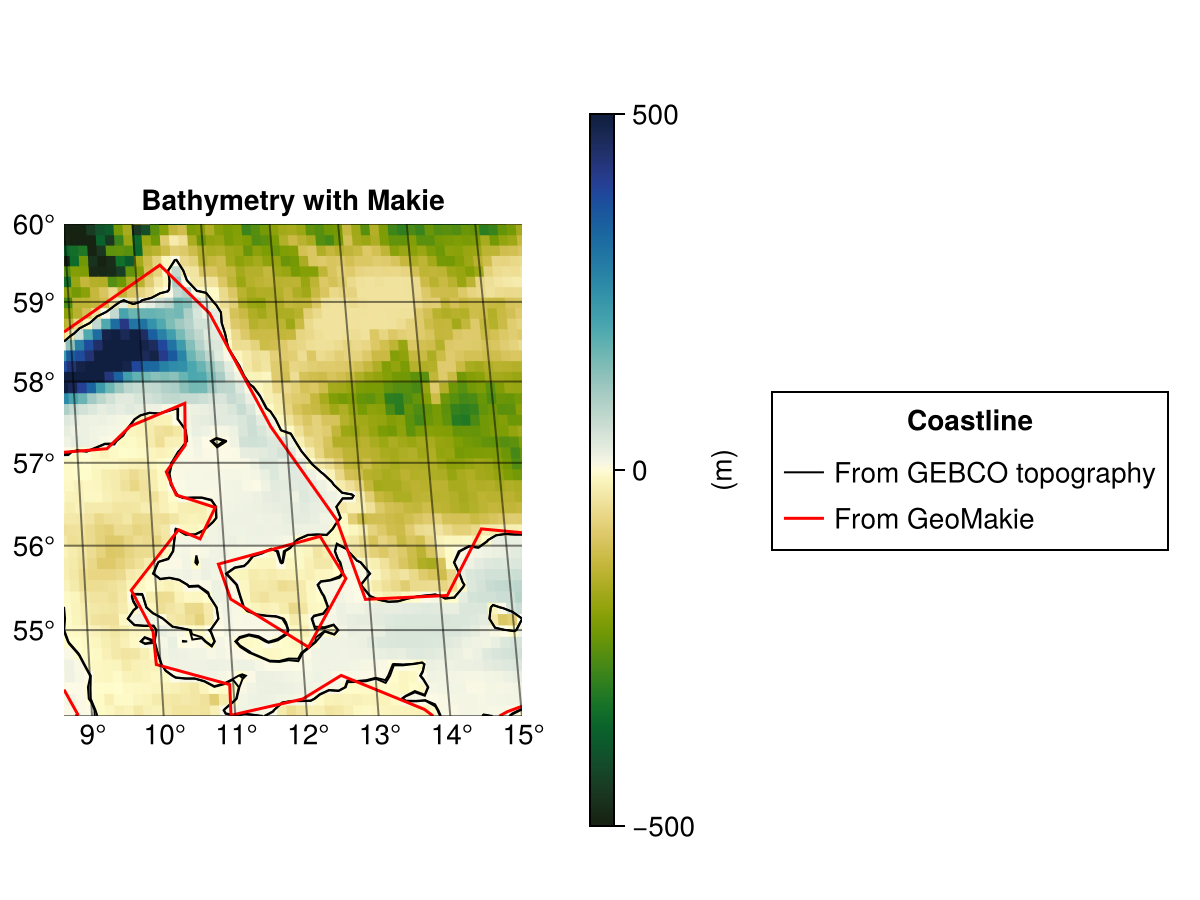

In [5]:
f = Figure()
ax = GeoAxis(f[1,1], title="Bathymetry with Makie", dest = "+proj=hatano")
hm = heatmap!(ax, bx, by, b, colormap=topocmap, colorrange=[-500, 500])
contour!(ax, bx, by, b, levels=[0., 1], color=:black, label="From GEBCO topography")
lines!(ax, GeoMakie.coastlines(), color=:red, label="From GeoMakie")
Colorbar(f[1,2], hm, label = "(m)")
f[1, 3] = Legend(f, ax, "Coastline")
xlims!(9.,15.)
ylims!(54., 60.)
f

### Land-sea mask
The mask contains `0`s and `1`s, we can display it using the function `heatmap` with for instance a black-and-white colormap (`:binary`).

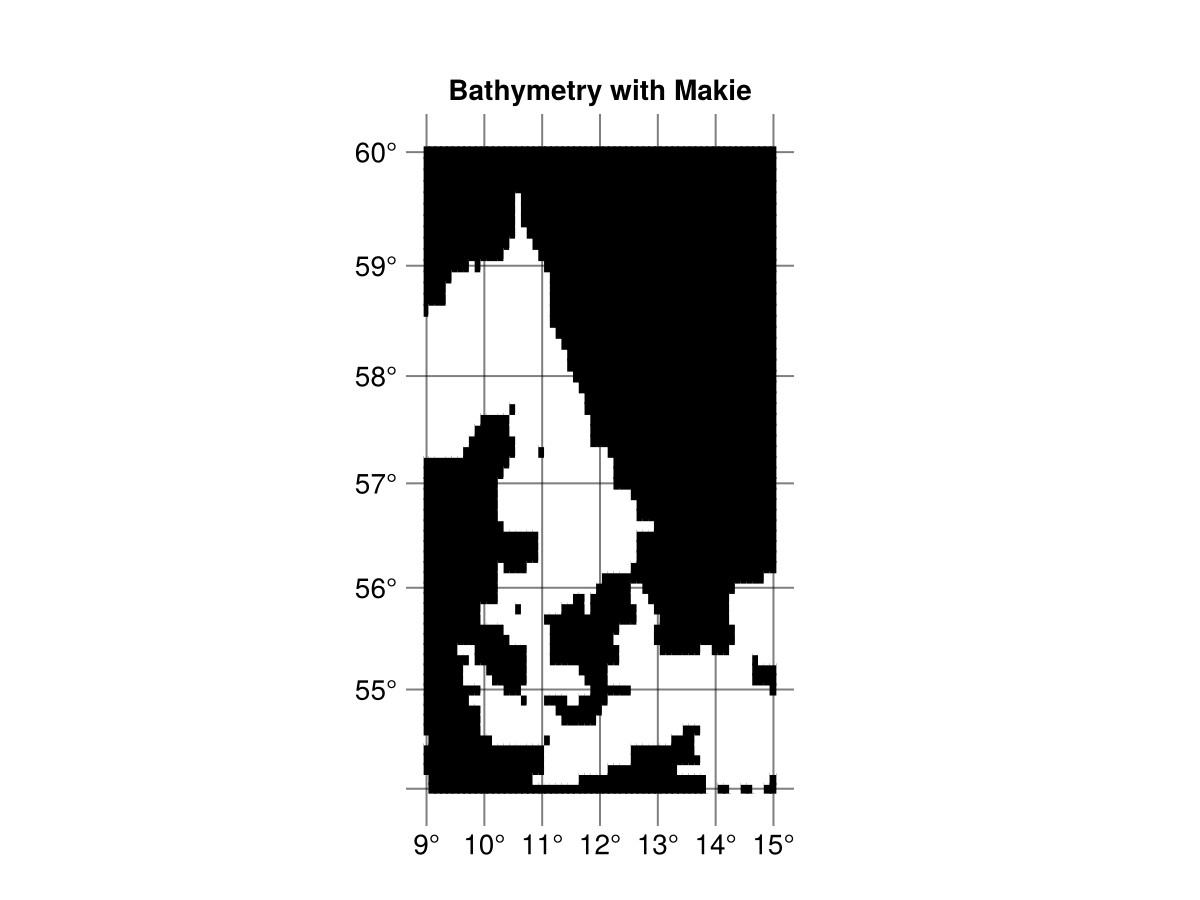

In [6]:
f = Figure()
ax = GeoAxis(f[1,1], title="Bathymetry with Makie", dest = "+proj=merc")
hm = heatmap!(ax, lonmask, latmask, mask[:,:,1], colormap=Reverse(:binary))
f

## Observations
### Load file
We work with salinity data in the Baltic Sea.

In [7]:
download_check(balticfile, balticfileURL)
obsvalue,obslon,obslat,obsdepth,obstime,obsids = loadobs(Float64, balticfile, "salinity");

[ Info: File already downloaded


In [8]:
sel = findall(obslon .<= 15.);
@info(length(sel))

[ Info: 6706067


### Figures
We can use either `Makie` (left panel) or `GeoMakie` (right panel) for the plots.        
#### Positions only

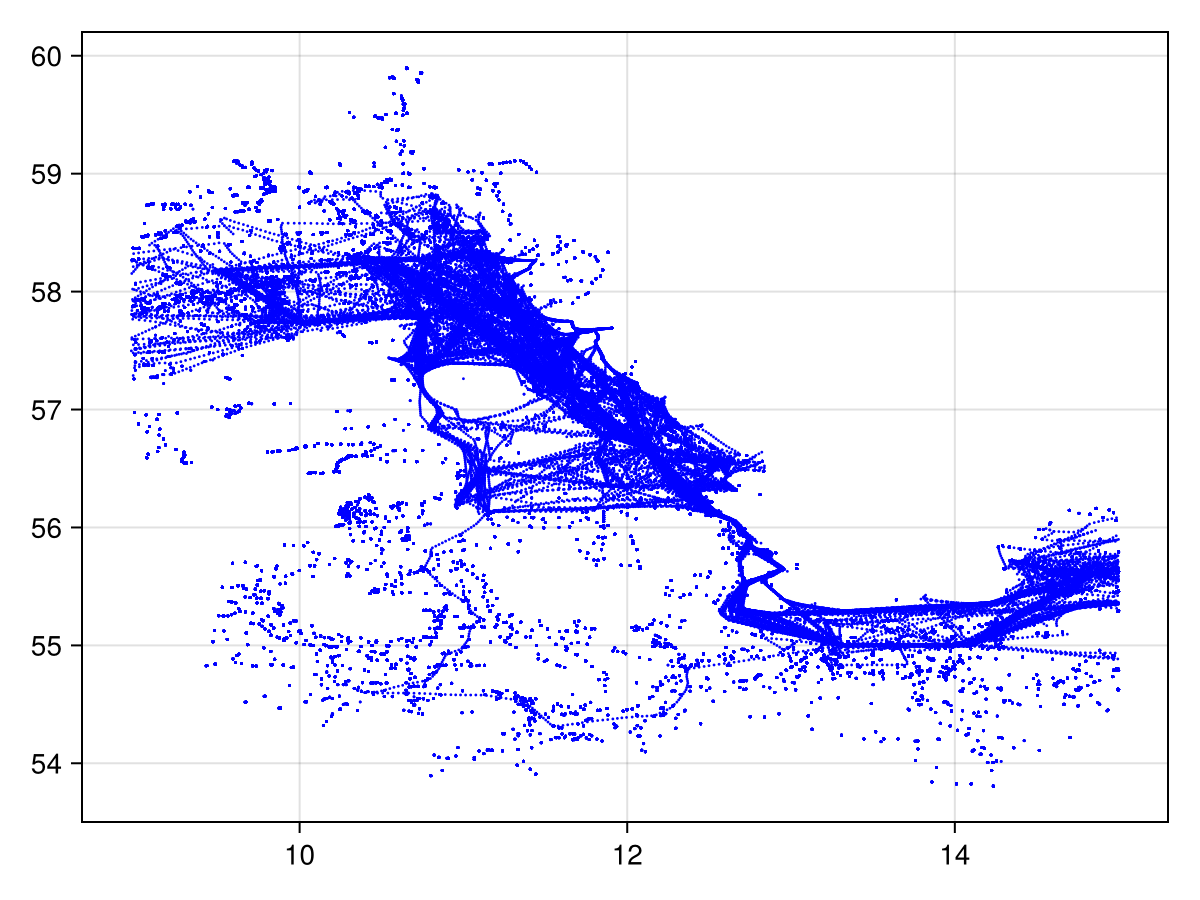

In [9]:
f = Figure()
ax1 = Axis(f[1,1])
plot!(ax1, obslon[sel], obslat[sel], color=:blue, markersize=2)
#ax2 = GeoAxis(f[1,2])
#plot!(ax2, obslon[sel], obslat[sel], color=:blue, markersize=2)
f

#### Scatter plot
The color depends on the data value

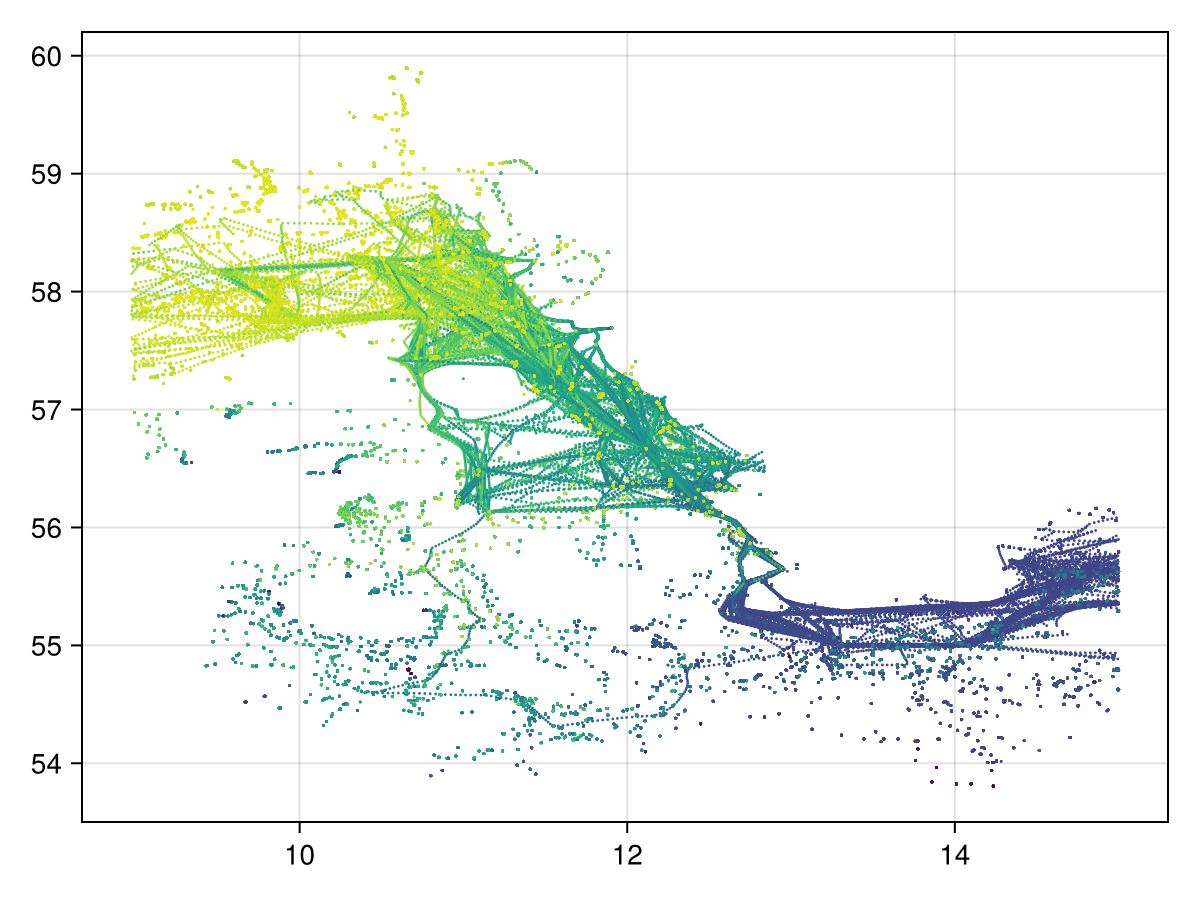

In [10]:
f = Figure()
ax = Axis(f[1,1])
plot!(ax, obslon[sel], obslat[sel], color=obsvalue[sel], markersize=2)
f

In [11]:
## Results
### Horizontal maps

In [12]:
### Vertical section